### Setup

In [240]:
!pip install scikit-image
# This is the change

In [120]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_multiotsu
from sklearn.mixture import GaussianMixture
import pandas as pd
import scipy.ndimage as nd

from random import randint
from glob import glob

In [2]:
root_dir = 'C:/Users/AIC/Desktop/Projects/Segmentation/Coffee-Semantic-Segmentation-main/data/external'
img_path_list = glob(os.path.join(root_dir, 'images/**/*.jpg'))
mask_path_list = [path.replace('images', 'annotations').replace('.jpg', '_mask.png') for path in img_path_list]

In [3]:
idx = randint(0, len(img_path_list))

img = cv2.imread(img_path_list[idx])
mask = cv2.imread(mask_path_list[idx])

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

### Image in Different Color Space

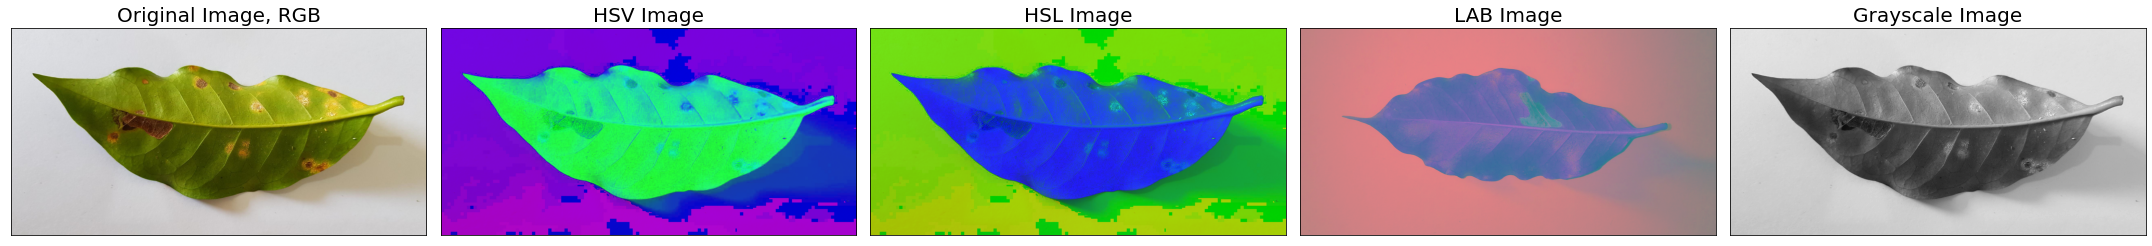

In [489]:
plt_idx = np.arange(5) + 151
img_list = [rgb_img, hsv_img, hls_img, lab_img, gray_img]
titles = ['Original Image, RGB', 'HSV Image', 'HSL Image', 'LAB Image', 'Grayscale Image']

plt.figure(figsize=(30,20))
for idx, img, title in zip(plt_idx, img_list, titles):
    plt.subplot(idx)
    if title == 'Grayscale Image':
        plt.imshow(img, cmap='gray')
        plt.title(title, size=20)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        continue

    plt.imshow(img)
    plt.title(title, size=20)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

plt.tight_layout()


### Image in Different Channels

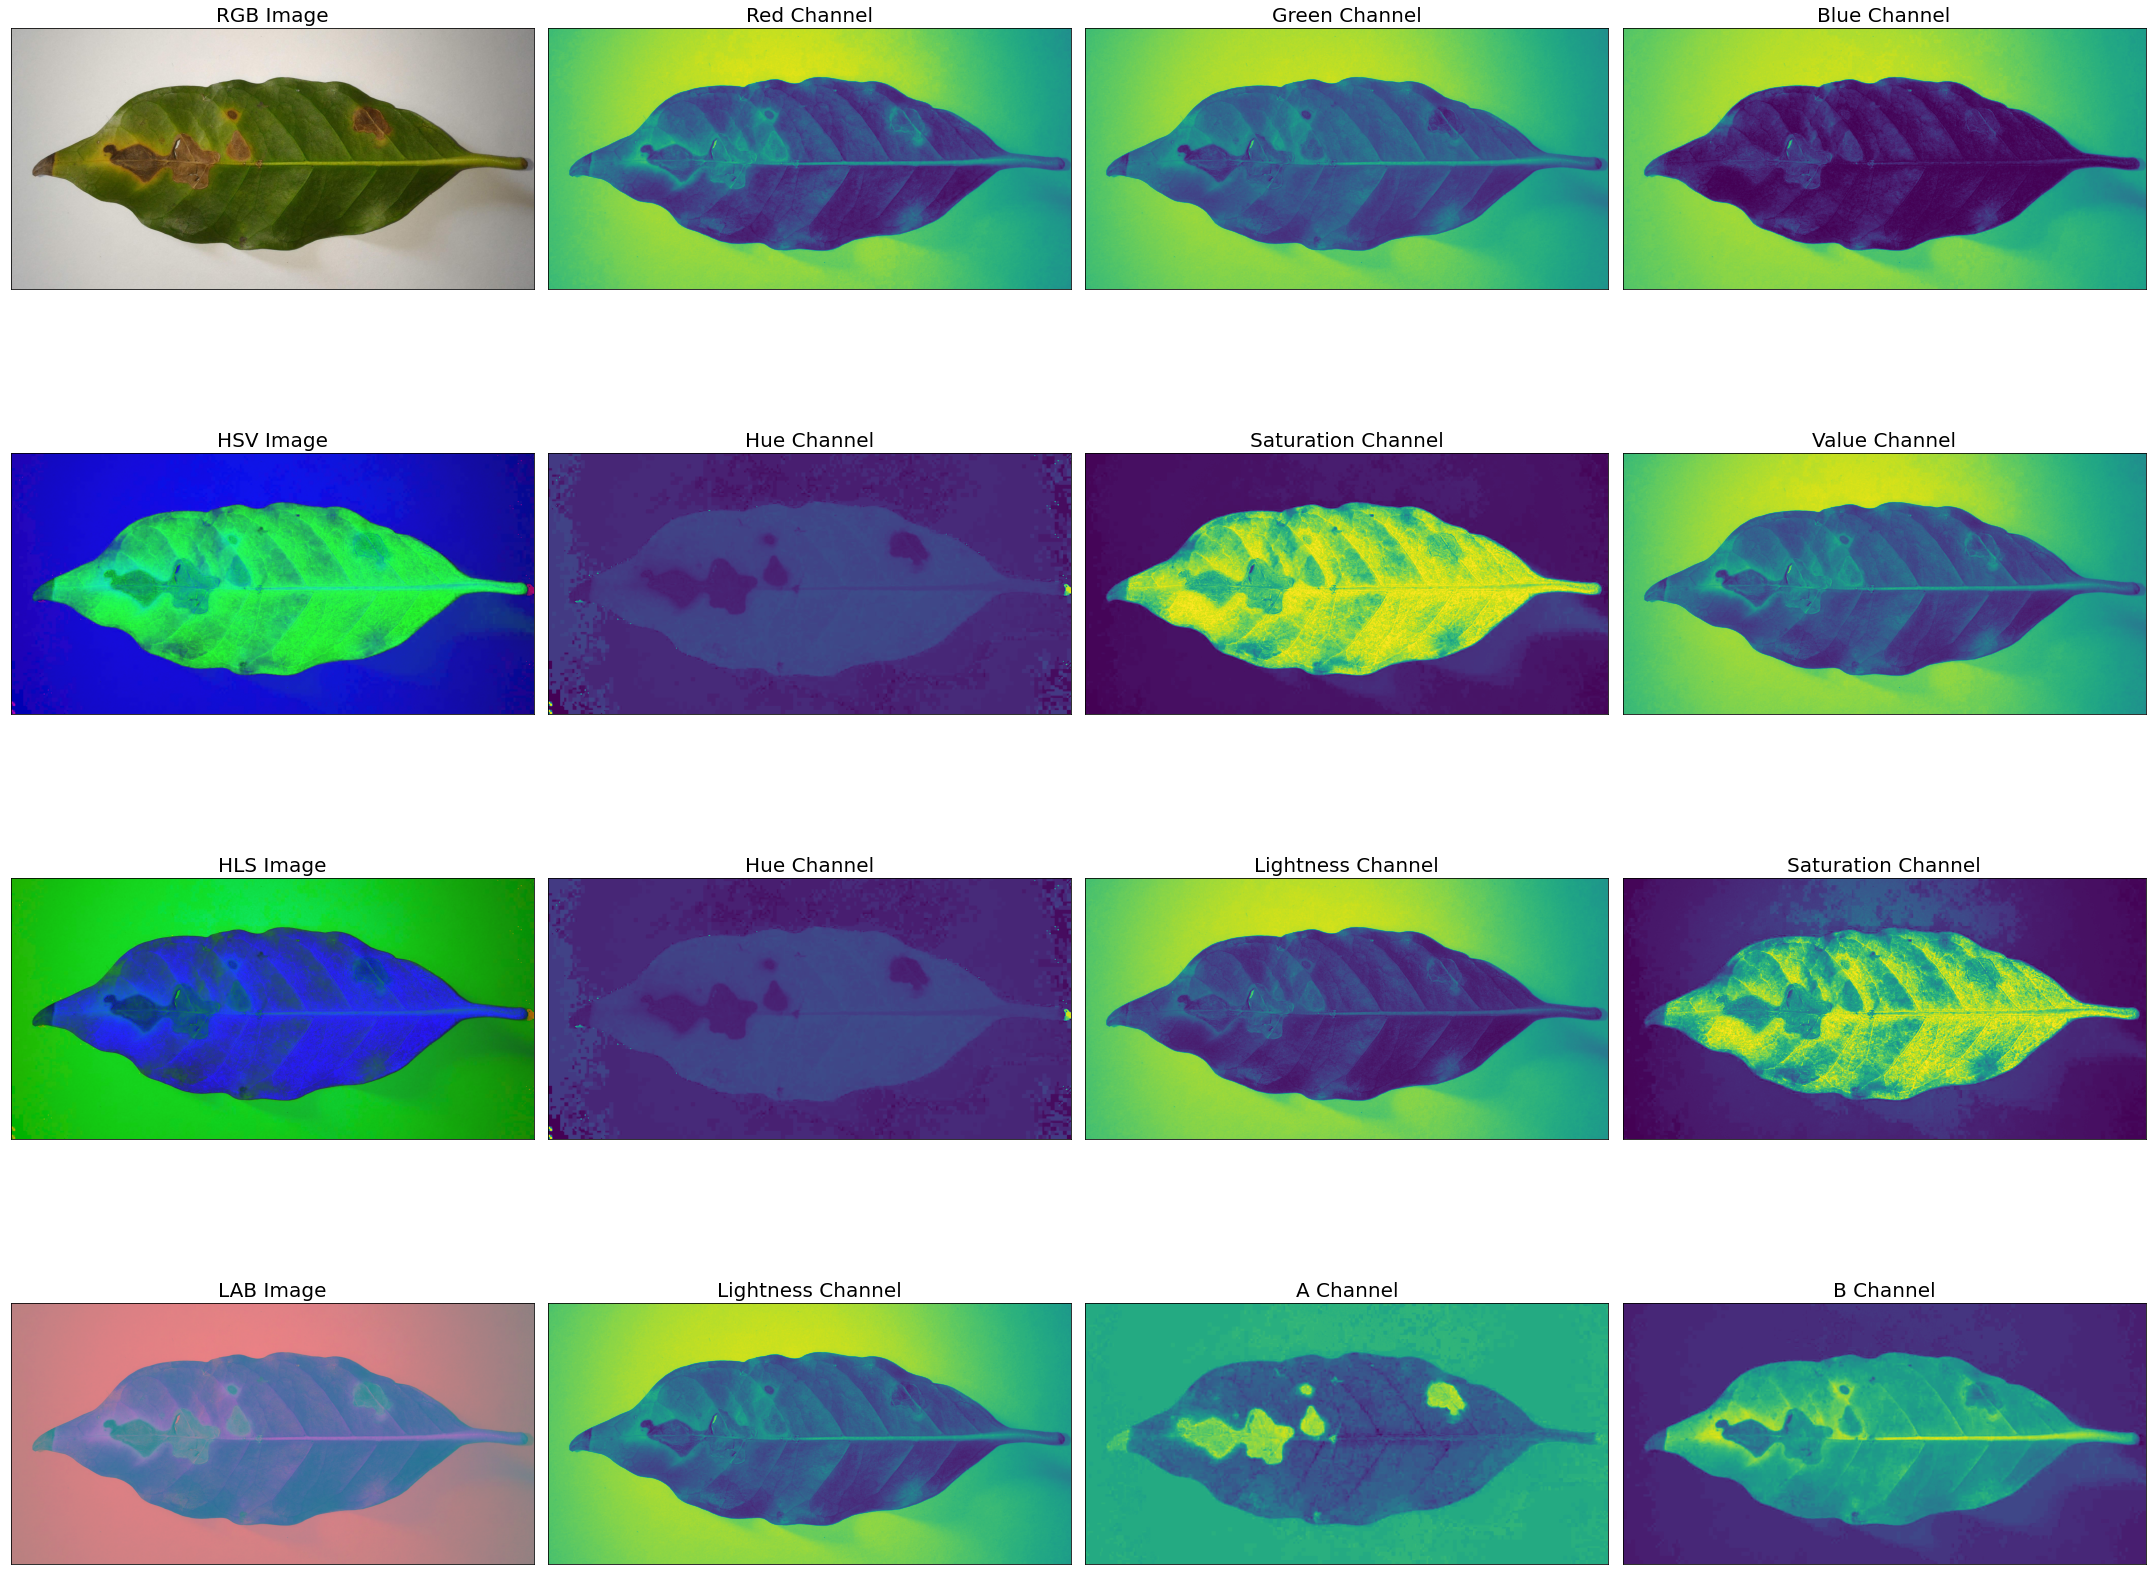

In [41]:
titles = [['RGB Image', 'Red Channel', 'Green Channel', 'Blue Channel'],
          ['HSV Image', 'Hue Channel', 'Saturation Channel', 'Value Channel'],
          ['HLS Image', 'Hue Channel', 'Lightness Channel', 'Saturation Channel'],
          ['LAB Image', 'Lightness Channel', 'A Channel', 'B Channel']]

img_list = [rgb_img, hsv_img, hls_img, lab_img]
channel_ids = np.arange(3)

_, ax = plt.subplots(nrows=4, ncols=4, subplot_kw={'xticks': [], 'yticks': []}, figsize=(30, 25))
for i, img in enumerate(img_list):
    for j in range(4):
        if j == 0:
            ax[i, j].imshow(img)
            ax[i, j].set_title(titles[i][j], size=20)
            continue           

        ax[i, j].imshow(img[:,:,j-1])        
        ax[i, j].set_title(titles[i][j], size=20)   
        
plt.tight_layout()


### Histograms for Different Color Spaces

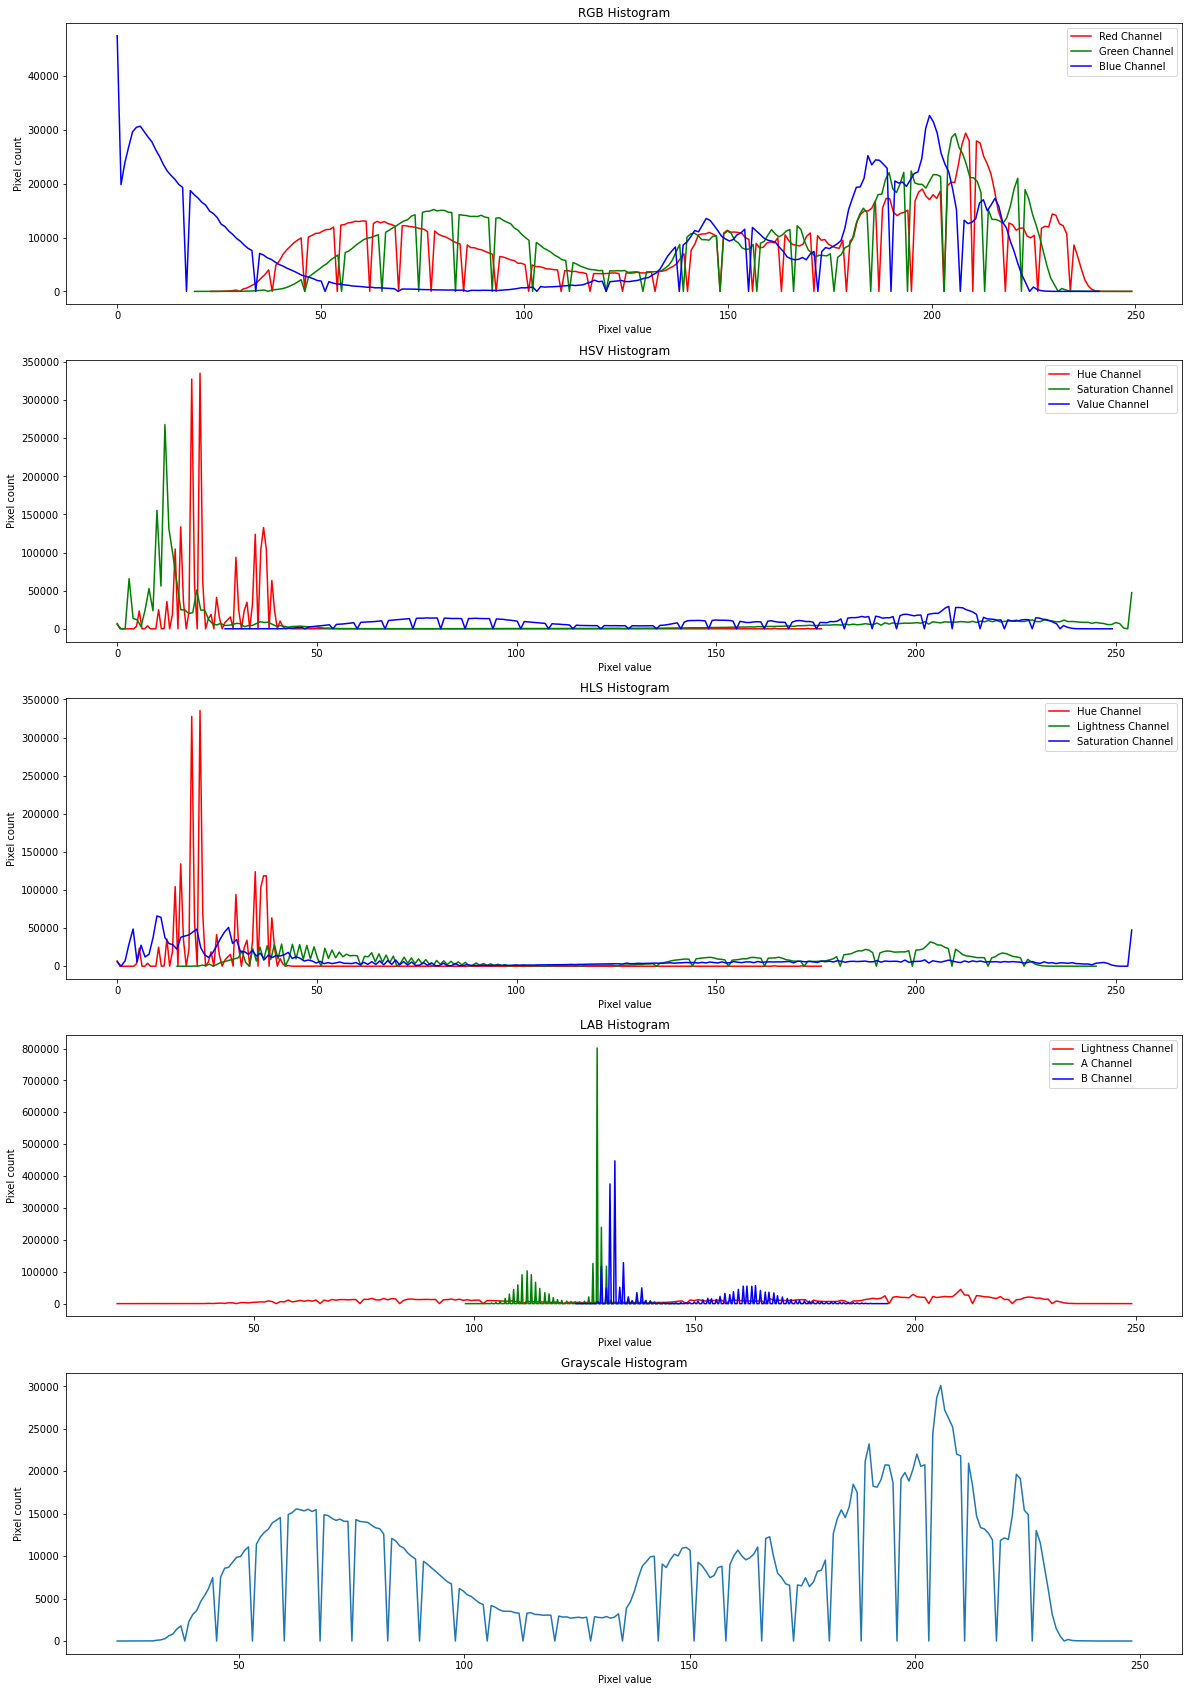

In [65]:
img_list = [rgb_img, hsv_img, hls_img, lab_img, gray_img]
titles = ['RGB Histogram', 'HSV Histogram', 'HLS Histogram', 'LAB Histogram', 'Grayscale Histogram']
labels =[['Red Channel', 'Green Channel', 'Blue Channel'], 
         ['Hue Channel', 'Saturation Channel', 'Value Channel'],  
         ['Hue Channel', 'Lightness Channel', 'Saturation Channel'],  
         ['Lightness Channel', 'A Channel', 'B Channel']]


colors = ['red', 'green', 'blue']
channel_ids = np.arange(3)
plt_idx_list = np.arange(5) + 511

plt.figure(figsize=(20, 30))
for i, (img, idx, title) in enumerate(zip(img_list, plt_idx_list, titles)):  

    if i == 4:
        plt.subplot(idx)
        hist, bin_edges = np.histogram(img, bins=256, range=(img.min(), img.max()))
        plt.plot(bin_edges[:-1], hist)        
        plt.title(title)
        plt.xlabel("Pixel value")
        plt.ylabel("Pixel count")
        continue
    
    plt.subplot(idx)
    for j, (channel_id, color) in enumerate(zip(channel_ids, colors)):
        # hist, bin_edges = np.histogram(img[:,:,channel_id], bins=256, range=(img.min(), img.max()))
        hist, bin_edges = np.histogram(img[:,:,channel_id], bins=256, range=(img[:,:,channel_id].min(), img[:,:,channel_id].max()))
        plt.plot(bin_edges[:-1], hist, color=color, label=labels[i][j])

    plt.legend()
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Pixel count")


### Comparing A-Channel of the LAB Image with the Mask

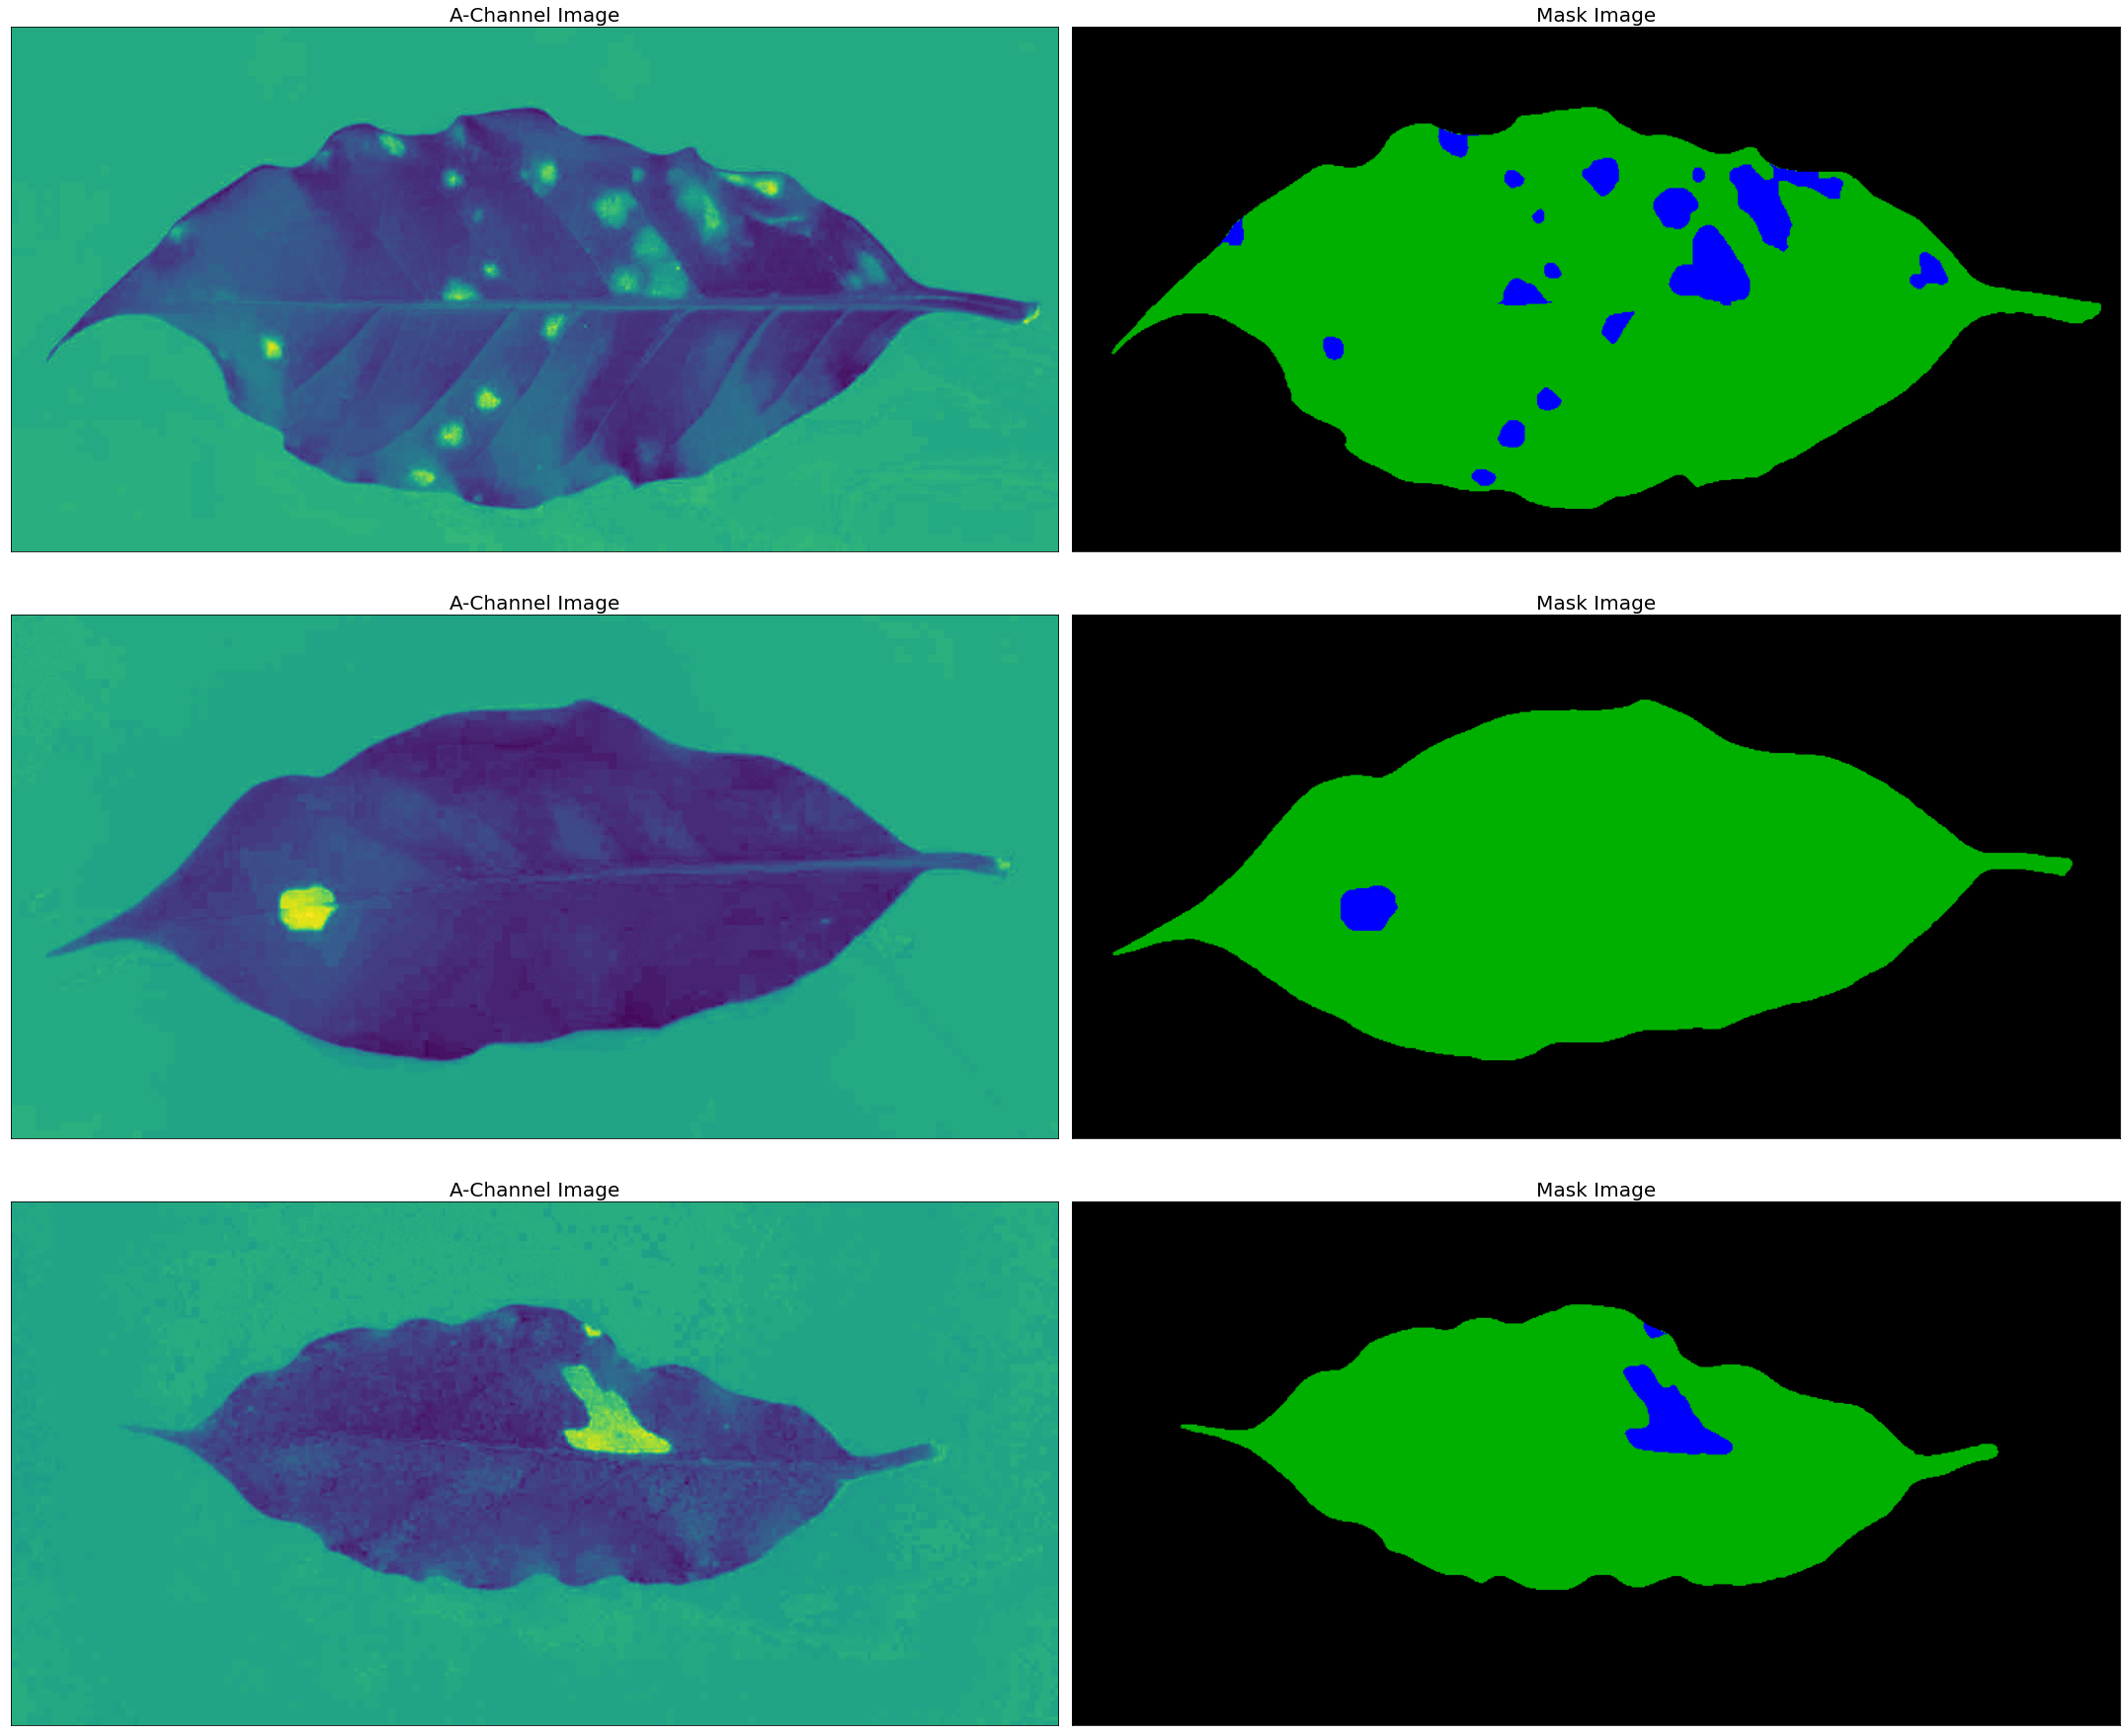

In [486]:
_, ax = plt.subplots(nrows=3, ncols=2, subplot_kw={'xticks': [], 'yticks': []}, figsize=(30, 25))
titles = ['A-Channel Image', 'Mask Image']
for i in range(3):
    idx = randint(0, len(img_path_list))

    for j, title, in enumerate(titles):
        img = cv2.imread(img_path_list[idx])
        mask = cv2.imread(mask_path_list[idx])
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        if j == 0:
            ax[i, j].imshow(lab_img[:,:,1])
            ax[i, j].set_title(title, size=20)
            continue

        ax[i, j].imshow(mask)
        ax[i, j].set_title(title,size=20)
plt.tight_layout()    

### Segmentation Using Multi-Otsu Thresholding

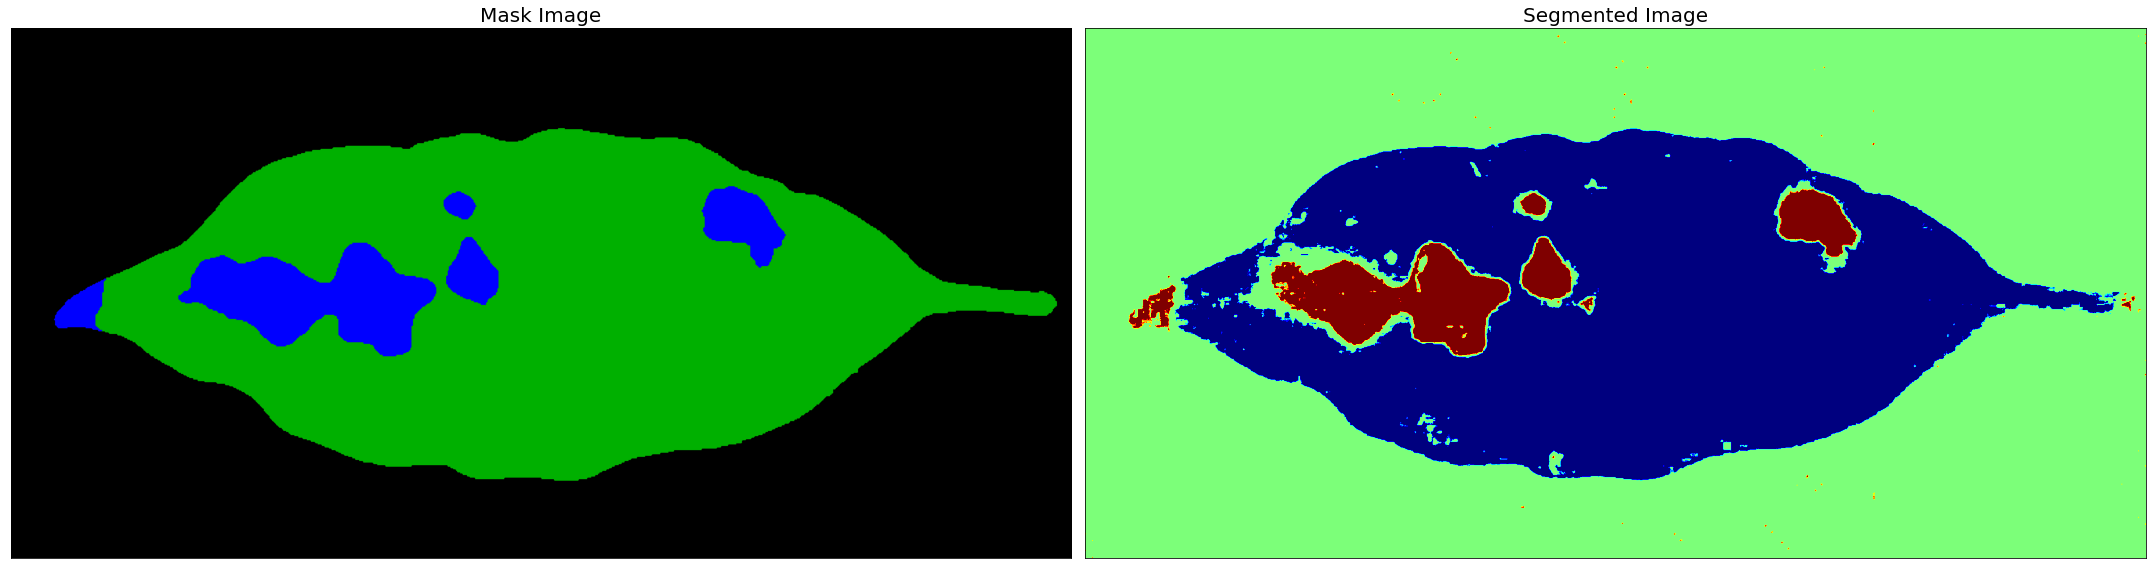

In [91]:
# find the two threshold values to segment the images into three regions(background, leaf, and the symptom)
a_channel_img = lab_img[:,:,1]
thresholds = threshold_multiotsu(a_channel_img)

# generate the three regions
regions = np.digitize(a_channel_img, bins=thresholds)

plt.figure(figsize=(30, 20))

plt.subplot(121)
plt.imshow(mask)
plt.title('Mask Image', size=20)
plt.xticks([]),plt.yticks([])

plt.subplot(122)
plt.imshow(regions, cmap='jet')
plt.title('Segmented Image', size=20)
plt.xticks([]),plt.yticks([])

plt.tight_layout()


[120 132]


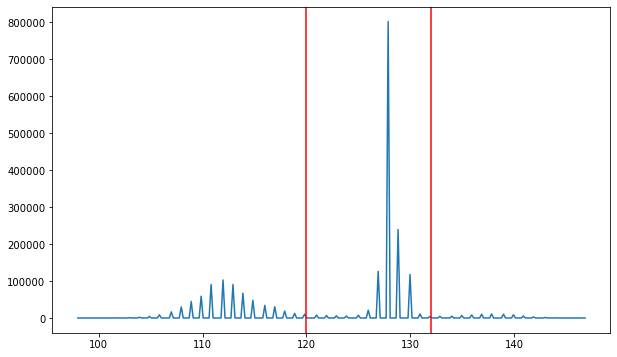

In [90]:
hist, bin_edges = np.histogram(a_channel_img, bins=256, range=(a_channel_img.min(), a_channel_img.max()))
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist)
for thresh in thresholds:
    plt.axvline(thresh, color='red')
print(thresholds)

### Segmentation Using K-Means

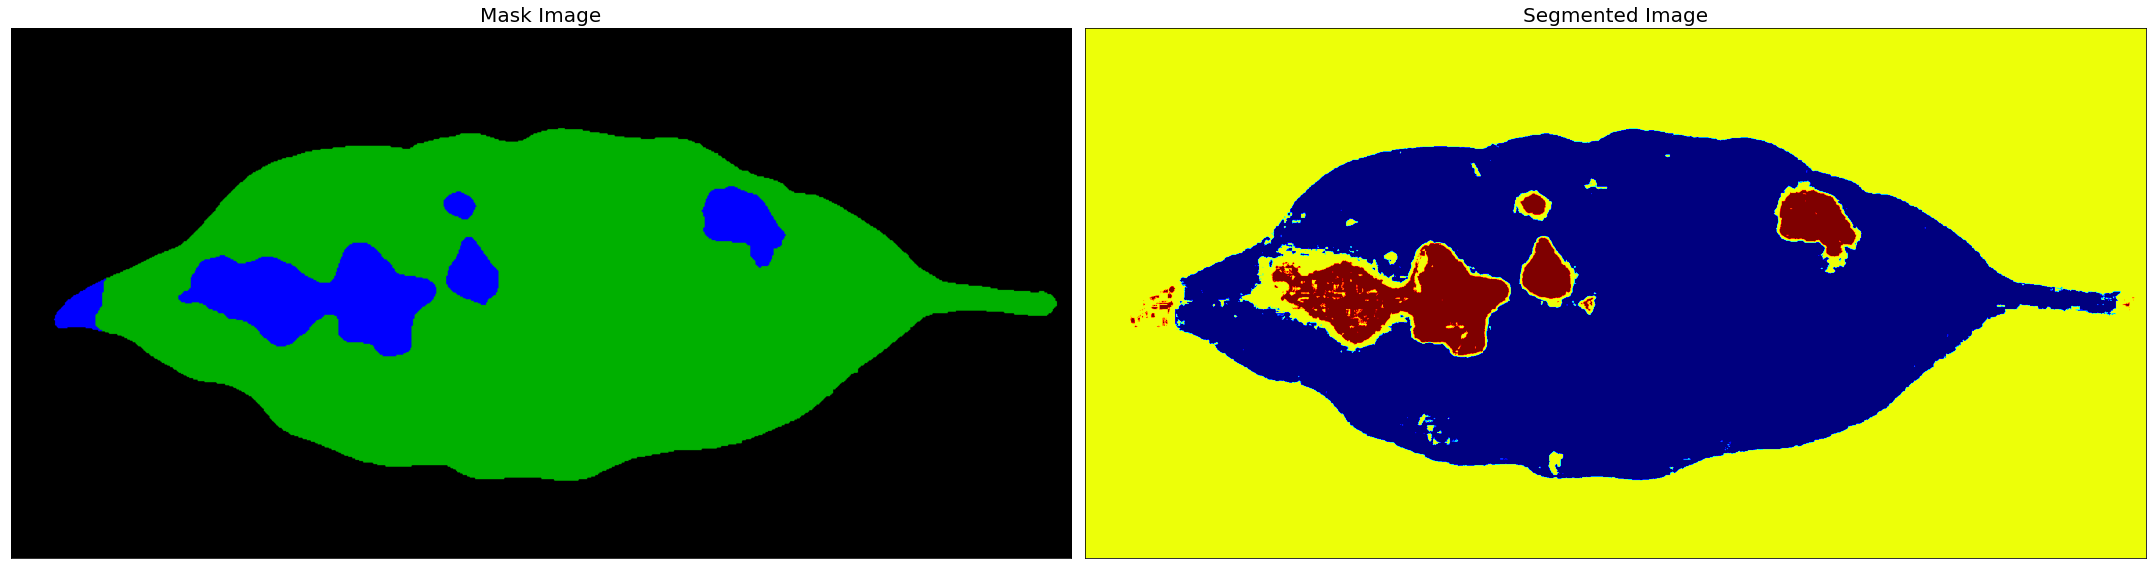

In [33]:
%matplotlib inline
# %matplotlib qt

a_channel_img = lab_img[:,:,1]

compactness, labels, centers = cv2.kmeans(
    data=np.reshape(np.float32(a_channel_img), (-1)), K=3,
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1.0),
    attempts=12,
    flags=cv2.KMEANS_RANDOM_CENTERS)


# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((a_channel_img.shape)) 

plt.figure(figsize=(30, 20))

plt.subplot(121)
plt.imshow(mask)
plt.title('Mask Image', size=20)
plt.xticks([]),plt.yticks([])

plt.subplot(122)
plt.imshow(segmented_image, cmap='jet')
plt.title('Segmented Image', size=20)
plt.xticks([]),plt.yticks([])

plt.tight_layout()



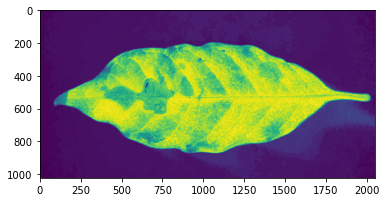

In [68]:
b_channel_img = lab_img[:,:,2]

saturation_channel_img = hsv_img[:,:,1]
# plt.imshow(b_channel_img)
plt.imshow(saturation_channel_img)

### Foreground Segmentation Using Simple Thresholding

120.0
148.0
113.0
99.0


Text(0.5, 1.0, 'Mask')

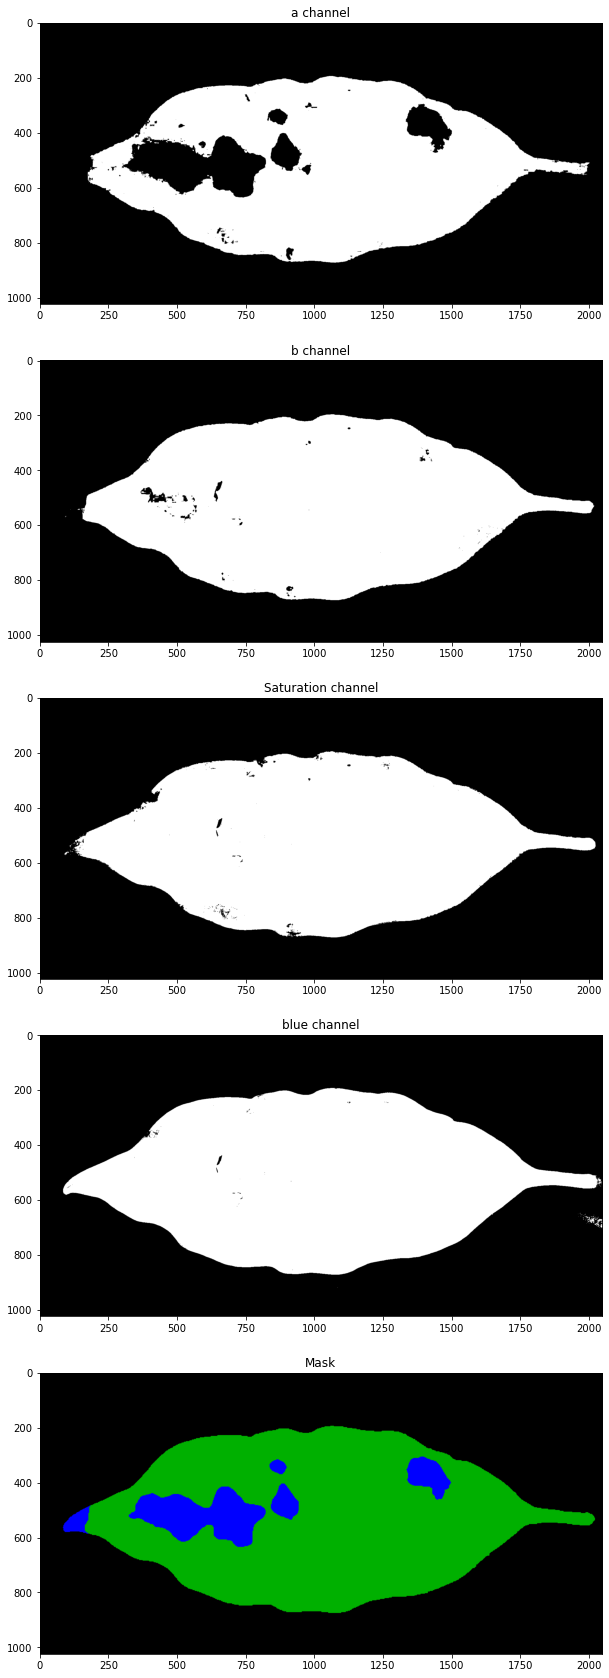

In [139]:
# blurred_img = cv2.GaussianBlur(b_channel_img, (23, 23), -1, -1)
# blurred_img = cv2.GaussianBlur(saturation_channel_img, (23, 23), -1, -1)
# blurred_img = cv2.bilateralFilter(a_channel_img, 11, 61, 39)

# thresh_val, thresh_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# thresh_val, thresh_img = cv2.threshold(saturation_channel_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# thresh_val, thresh_img = cv2.threshold(b_channel_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# thresh_val, thresh_img = cv2.threshold(a_channel_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# plt.imshow(thresh_img, cmap='gray')
# print(thresh_val)


plt.figure(figsize=(20, 30))
plt.subplot(511)
thresh_val, thresh_img = cv2.threshold(a_channel_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.title('a channel')
plt.imshow(thresh_img, cmap='gray')
print(thresh_val)


plt.subplot(512)
thresh_val, thresh_img = cv2.threshold(b_channel_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(thresh_img, cmap='gray')
plt.title('b channel')
print(thresh_val)


plt.subplot(513)
thresh_val, thresh_img = cv2.threshold(saturation_channel_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(thresh_img, cmap='gray')
plt.title('Saturation channel')

print(thresh_val)

plt.subplot(514)
thresh_val, thresh_img = cv2.threshold(rgb_img[:,:,2], 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print(thresh_val)
plt.imshow(thresh_img, cmap='gray')
plt.title('blue channel')

plt.subplot(515)
plt.imshow(mask)
plt.title('Mask')




# #visualize only the masked regions in the image
# masked = cv2.bitwise_and(b_channel_img, b_channel_img, mask=thresh_img)
# # masked = cv2.bitwise_and(a_channel_img, a_channel_img, mask=thresh_img)
# # masked = cv2.bitwise_and(saturation_channel_img, saturation_channel_img, mask=thresh_img)

# plt.imshow(masked, cmap='gray')

#### Filling Holes on the Blue Channel Mask

### Segmentation using Gaussian Mixture Model(GMM)


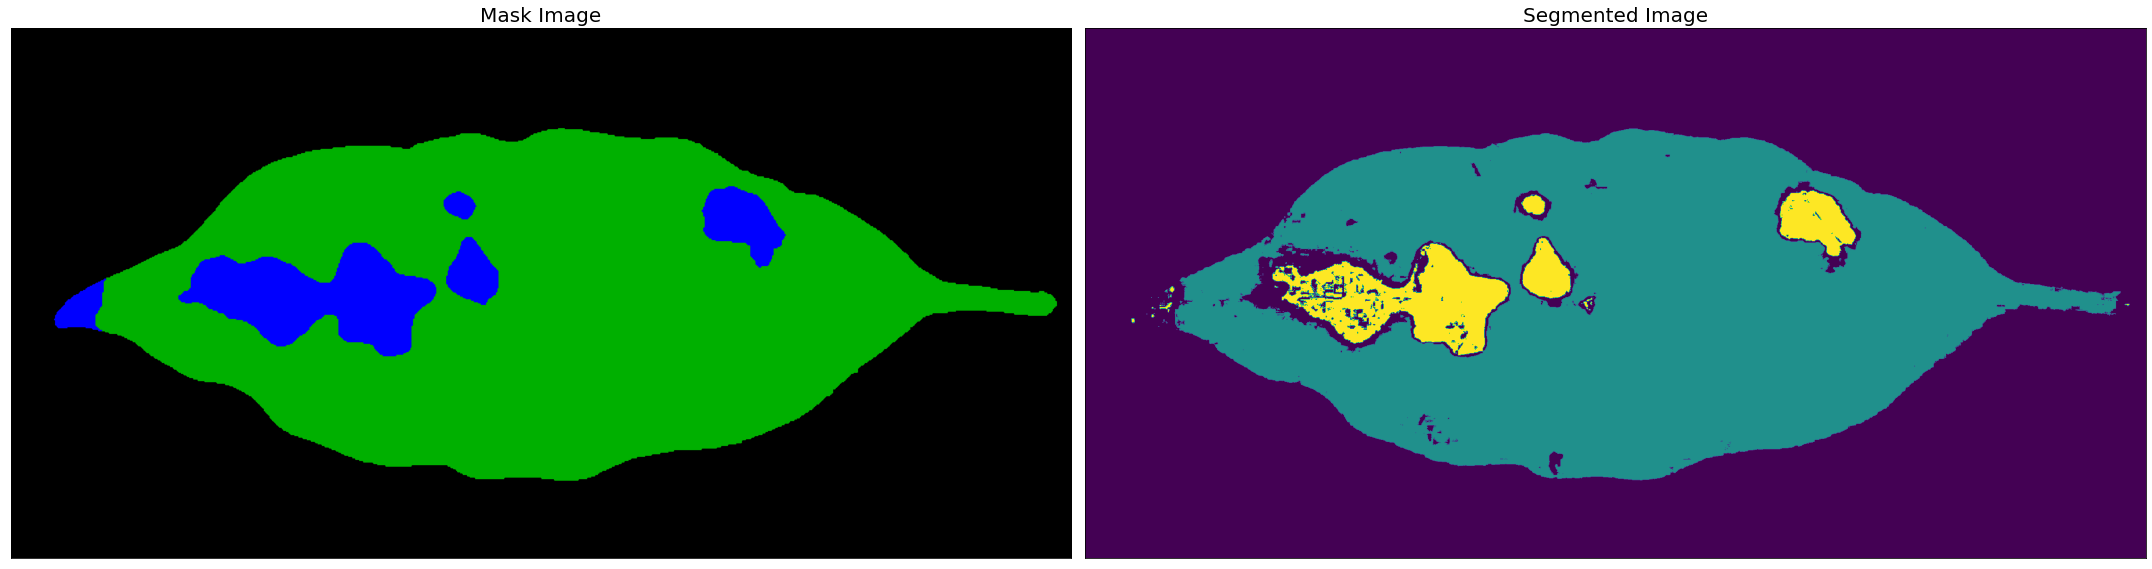

In [89]:
flat_img = a_channel_img.reshape((-1, 1))

gmm_model = GaussianMixture(n_components=3, covariance_type='tied').fit(flat_img)
gmm_labels = gmm_model.predict(flat_img)

segmented_img = gmm_labels.reshape(a_channel_img.shape)

plt.figure(figsize=(30, 20))

plt.subplot(121)
plt.imshow(mask)
plt.title('Mask Image', size=20)
plt.xticks([]),plt.yticks([])

plt.subplot(122)
plt.imshow(segmented_img)
plt.title('Segmented Image', size=20)
plt.xticks([]),plt.yticks([])

plt.tight_layout()


In [78]:
help(np.stack)

Help on function stack in module numpy:

stack(arrays, axis=0, out=None)
    Join a sequence of arrays along a new axis.
    
    The ``axis`` parameter specifies the index of the new axis in the
    dimensions of the result. For example, if ``axis=0`` it will be the first
    dimension and if ``axis=-1`` it will be the last dimension.
    
    .. versionadded:: 1.10.0
    
    Parameters
    ----------
    arrays : sequence of array_like
        Each array must have the same shape.
    
    axis : int, optional
        The axis in the result array along which the input arrays are stacked.
    
    out : ndarray, optional
        If provided, the destination to place the result. The shape must be
        correct, matching that of what stack would have returned if no
        out argument were specified.
    
    Returns
    -------
    stacked : ndarray
        The stacked array has one more dimension than the input arrays.
    
    See Also
    --------
    concatenate : Join a sequenc

### Adaptive Thesholding

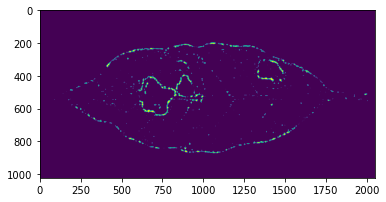

In [37]:
# thresh_ = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 5)
thresh_ = cv2.adaptiveThreshold(a_channel_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 5)
# thresh_ = cv2.adaptiveThreshold(hsv_img[:,:,2], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 5)
plt.imshow(thresh_)
# plt.imshow(blurred_img)

### Foreground Segmentation Using Edge Based Methods

In [95]:
np.unique(a_channel_img, return_counts=True)

(array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147], dtype=uint8),
 array([     2,     27,     63,    131,    312,    824,   1998,   4093,
          8587,  16489,  29834,  44495,  58859,  90507, 102778,  90691,
         66976,  47712,  34079,  30464,  18698,  12553,  10302,   7810,
          6483,   5754,   5234,   7430,  20940, 125901, 801590, 239301,
        117461,  10871,   4030,   4260,   4891,   6700,   8225,  10045,
         10807,  10163,   8698,   5395,   2822,   1413,    354,     89,
            10,      1], dtype=int64))

In [99]:
low_thresh = 114
high_thresh = 128
edges = cv2.Canny(a_channel_img, low_thresh, high_thresh)
plt.imshow(edges, cmap='gray')


In [118]:
# blurred_img = cv2.bilateralFilter(a_channel_img, 11, 61, 39)
blurred_img = cv2.bilateralFilter(saturation_channel_img, 11, 61, 39)

# cv2.imshow('cat', blurred_img)



def TrackbarFunc(val):
    low_thresh = cv2.getTrackbarPos('Low Threshold', 'Canny Edge Detection')
    high_thresh = cv2.getTrackbarPos('High Threshold', 'Canny Edge Detection')
    # edges = cv2.Canny(a_channel_img, low_thresh, high_thresh)
    edges = cv2.Canny(blurred_img, low_thresh, high_thresh)
    cv2.imshow('Canny Edge Detection', edges)
    # cv2.imshow('Canny Edge Detection', edges)

cv2.namedWindow('Canny Edge Detection')
# cv2.createTrackbar('Low Threshold', 'Canny Edge Detection', 114, 150, TrackbarFunc)
# cv2.createTrackbar('High Threshold', 'Canny Edge Detection', 114, 150, TrackbarFunc)


cv2.createTrackbar('Low Threshold', 'Canny Edge Detection', 114, 255, TrackbarFunc)
cv2.createTrackbar('High Threshold', 'Canny Edge Detection', 114, 255, TrackbarFunc)

TrackbarFunc(0)
cv2.waitKey(0)
cv2.destroyAllWindows()





error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:862: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


In [122]:
# blurred_img = cv2.GaussianBlur(gray_img, (23, 23), -1, -1)
blurred_img = cv2.bilateralFilter(saturation_channel_img, 11, 61, 39)
# plt.imshow(blurred_img, cmap='gray')


low_thresh = 0
high_thresh = 255
edges = cv2.Canny(blurred_img, low_thresh, high_thresh)
# edges = cv2.Canny(gray_img, low_thresh, high_thresh)

filled_img = nd.binary_fill_holes(edges)
plt.imshow(filled_img, cmap='gray')

In [127]:

ksize = -1
# ksize = 3

gX = cv2.Sobel(a_channel_img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(a_channel_img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)

combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

plt.imshow(combined)

In [124]:


elevation_map = cv2.Sobel(a_channel_img)
plt.imshow(elevation_map)

# Since, the contrast difference is not much. Anyways we will perform it
markers = np.zeros_like(a_channel_img)
markers[rocket_wh < 0.1171875] = 1 # 30/255
markers[rocket_wh > 0.5859375] = 2 # 150/255

plt.imshow(markers)
plt.title('markers')

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'Sobel'
> Overload resolution failed:
>  - Sobel() missing required argument 'ddepth' (pos 2)
>  - Sobel() missing required argument 'ddepth' (pos 2)


In [ ]:

# different ways to plot histogram

# counts, values= np.unique(gray_img, return_counts=True)
# plt.plot(values, counts)

# counts, values = np.histogram(gray_img, bins=256, range=(0, 255))
# plt.plot(values[:-1], counts)
# the bins is set to 256, since we want to see the pixel counts for each grayscale values
# print(len(values))
# print(len(counts)) # the last element is the stop value of the histogram

plt.hist(gray_img.flatten(), bins=256, range=(0, 255))
plt.xlabel('Grayscale Value')
plt.ylabel('Pixel Count')
plt.title('Grayscale Histogram')